<a href="https://colab.research.google.com/github/HarryGateaux/PyTorchLearning/blob/master/PyTorch_Data_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basics of loading custom data with PyTorch 


These are my notes as I'm learning PyTorch and Python
<br><br>
I thought I'd show a couple of approaches to loading data from a personal dataset.
<br><br>
Most examples online involve premade datasets/folder structures so I figured this might be handy
<br><br>
This 101 guide was a great reference:

https://blog.paperspace.com/pytorch-101-building-neural-networks/



Link colab to google drive

In [5]:
#sets up colab to access/save data to google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

from pathlib import Path

root_dir = Path("/content/gdrive/My Drive/Colab Notebooks/")
data_dir = root_dir/'toy_data'


Mounted at /content/gdrive


Creating a fake dataset in my google drive


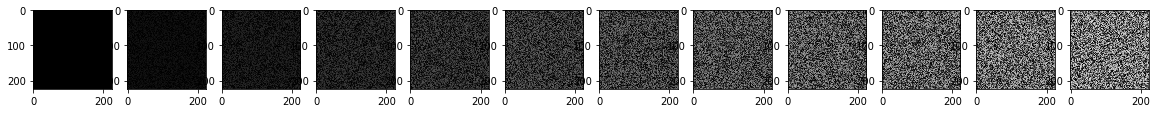

In [65]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

toy_images = []

#generate random 224 x 224 images
for i in range(12):
  pixels = np.random.rand(224, 224)
  img = Image.fromarray(pixels * 20 * i).convert('RGB')
  toy_images.append(img)

#plot them for sanity check
fig, ax = plt.subplots(1, len(toy_images), figsize = (20, 40))

for index, image in enumerate(toy_images):

  ax[index].imshow(image)

plt.show()

#save them to disk with following format (image_num_label.jpg)
labels = [0, 1]

for index, image in enumerate(toy_images):

  label = random.choice(labels) #assign random label
  data_dir.mkdir(parents=True, exist_ok=True) #create folder if not present
  filename = 'image_' + str(index) + '_' + str(label) + '.jpg'
  image.save(data_dir/filename)

#Approach 1 : Loading the data into a PyTorch Dataset + Dataloader manually
<br>
steps


*  retrieve images + labels from folder
*  convert to numpy format
*  combine into 2 tensors, one for images, one for labels
*  pass these into dataset object
*  pass that into dataloader object



In [0]:
import torch
from torchvision import transforms

#reading in the toy images from drive
image_files = list(data_dir.iterdir())
images = []
labels = []

#load images and labels into lists
for file in image_files:
  images.append(Image.open(file))
  labels.append(int(file.stem[-1:]))

#creating tuples of the statistics used when training the model (for each dimension)
#these are the statistics from VGG model and just used here to show how it works

sample_means = (0.485, 0.456, 0.406)
sample_stdev = (0.229, 0.224, 0.225)

#create image transforms using PyTorch inbuilt transforms object
tfms = transforms.Compose([
                    transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize(sample_means, sample_stdev)])

#convert images to np arrays
image_tensors = [tfms(im) for im in images]
label_tensors = [torch.tensor(label) for label in labels]

#convert each into single tensor
tensor_images = torch.stack(image_tensors)
tensor_labels = torch.stack(label_tensors)

#creating a pytorch dataset object 'manually'
dataset1 = torch.utils.data.TensorDataset(tensor_images, tensor_labels)

#assign the dataset to a dataloader
dataloader1 = torch.utils.data.DataLoader(dataset, batch_size=2)


#Dataset
<br>
This is a Pytorch data structure essentially a generator




In [68]:
#print out the image tensor + label tensor pairings
for image, label  in dataset1:
  print(image.shape,label)


torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(1)


#Dataloader
<br>
This is a Pytorch data structure that takes Dataset as input, again a kind of generator.<br> Gives extra functionality (extracting batches from data, converting to tensors, multi-threading etc)

In [69]:
#earlier I made a batch size of two
#print out the batches of images + label tensors
for images, labels  in dataloader1:
  print(images.shape,labels)

#these are what the model loops over in the training step

torch.Size([2, 3, 224, 224]) tensor([0, 1])
torch.Size([2, 3, 224, 224]) tensor([1, 0])
torch.Size([2, 3, 224, 224]) tensor([0, 1])
torch.Size([2, 3, 224, 224]) tensor([0, 1])
torch.Size([2, 3, 224, 224]) tensor([0, 0])
torch.Size([2, 3, 224, 224]) tensor([0, 0])


#Approach 2 : Creating a dataset by subclassing the PyTorch dataset object
<br>


This requires three dunder methods to be implemented in the subclass:
<br>
<br>
 __init__ , __len__ and __getitem__
 <br>
 <br>
 It's a bit more work but nice to have all the steps embedded in a single object for modularity
 <br>
 <br>
 NB: I should probably add some checks/tests within the CustomDataset when accessing data etc. But keeping code to bare minimum for illustration



In [0]:
import os

class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, data_location):
    
    image_files = os.listdir(data_location) #get image file names
    self.image_files = [os.path.join(data_location,x) for x in image_files] #get full path for files

    self.size = len(image_files) #set dataset size
    self.transforms = transforms.Compose([transforms.Resize(224),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), 
                                          (0.229, 0.224, 0.225))]) #define transforms for when loading images into dataset
    
  def __len__(self):
    return self.size

  def __getitem__(self, idx):

    image_file = self.image_files[idx] #retrieve file path at index
    image = Image.open(image_file) #open that file
    image = self.transforms(image) #apply the transforms defined in __init__

    label = Path(self.image_files[idx]).stem[-1:] #get the label which is the last character of the file stem
    label = torch.tensor(int(label))

    return image, label


Test it works!


In [71]:
dataset2 = CustomDataset(data_dir)

print('dataset\n')
for image, label in cd:
  print(image.shape, label)

dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size=2)

print('\ndataloader\n')
for images, labels in dl:
  print(images.shape, labels)

dataset

torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(1)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(0)
torch.Size([3, 224, 224]) tensor(0)

dataloader

torch.Size([2, 3, 224, 224]) tensor([0, 1])
torch.Size([2, 3, 224, 224]) tensor([1, 0])
torch.Size([2, 3, 224, 224]) tensor([0, 1])
torch.Size([2, 3, 224, 224]) tensor([0, 1])
torch.Size([2, 3, 224, 224]) tensor([0, 0])
torch.Size([2, 3, 224, 224]) tensor([0, 0])


#Test the data works in a model

In [0]:
from torchvision import models

In [73]:
#load pretrained vgg16 model, this classifies input images into one of 1000 classes
model = models.vgg16(pretrained=True)

print("dataloader approach 1 \n")
for images, labels in dataloader:

  pred = model(images)
  print(f"shape of output : {pred.shape}") # expect a shape of (2, 1000) because batch size is 2
  print(f"argmaxs of output : {torch.argmax(pred,1)}") # expect 2 outputs, a predicted class for each image in the batch


print("\ndataloader approach 2 \n")
for images, labels in dataloader2:

  pred = model(images)
  print(f"shape of output : {pred.shape}") # expect a shape of (2, 1000) because batch size is 2
  print(f"argmaxs of output : {torch.argmax(pred,1)}") # expect 2 outputs, a predicted class for each image in the batch

#the outputs are clearly not accurate as just passing in random noise images

dataloader approach 1 

shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([644, 111])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([530, 111])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([885, 879])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([977, 977])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([977, 980])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([562, 980])

dataloader approach 2 

shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([111, 111])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([111, 111])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([885, 904])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([539, 539])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([977,   6])
shape of output : torch.Size([2, 1000])
argmaxs of output : tensor([562, 562])
sha

Could also loop over the dataset if we really wanted to<br><br>
Not much point though as we lose PyTorch optimisation<br><br>
Also note that we have to unsqueeze the first dimension of the image because model expects input of size (batch_size, channel, h, w)

In [74]:
for image, label in dataset:

  unsqueezed_image = image.unsqueeze(0)
  pred = model(unsqueezed_image)
  print(f"shape of output : {pred.shape}") # expect a shape of (1, 1000) as we are passing single images
  print(f"argmaxs of output : {torch.argmax(pred,1)}") # expect 1 output, a predicted class the image in the batch


shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([111])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([111])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([644])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([111])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([885])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([980])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([539])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([977])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([977])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([562])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([980])
shape of output : torch.Size([1, 1000])
argmaxs of output : tensor([562])
